# Heart Disease Classification using Support Vector Machine (SVM)

## Dataset: Heart Disease Classification Dataset (CSE422_BRAC)
**Author**: [Nagesh Desai]  
**Date**: September 19, 2025

### Project Overview
This notebook implements Support Vector Machine (SVM) for binary classification of heart disease presence/absence. The dataset contains 15 clinical features including age, gender, chest pain type, blood pressure, cholesterol levels, and other cardiovascular indicators from BRAC University research.

### Dataset Information
- **Source**: BRAC University (CSE422)
- **Size**: 13.93KB, 303 samples
- **Features**: 15 columns (14 features + 1 target)
- **Task**: Binary classification (0=No Disease, 1=Disease Present)
- **Domain**: Medical diagnosis and cardiovascular health

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, validation_curve
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, 
    precision_score, recall_score, f1_score, roc_curve, auc,
    roc_auc_score, precision_recall_curve, average_precision_score
)
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.pipeline import Pipeline
import joblib
from collections import Counter
import time

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('default')
pd.set_option('display.max_columns', None)
np.random.seed(42)

print("Libraries imported successfully")
print(f"Pandas: {pd.__version__}, NumPy: {np.__version__}")

Libraries imported successfully
Pandas: 2.2.3, NumPy: 1.26.4


## 1. Data Loading and Initial Exploration

In [2]:
# Load the heart disease dataset
# Update the file path according to your dataset location
print("Loading Heart Disease Classification Dataset...")

# Load data
data = pd.read_csv('heart disease classification dataset.csv')  # Update path as needed

print(f"Dataset shape: {data.shape}")
print(f"Columns: {list(data.columns)}")
print("\nDataset loaded successfully")

Loading Heart Disease Classification Dataset...
Dataset shape: (303, 15)
Columns: ['Unnamed: 0', 'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

Dataset loaded successfully


In [3]:
# Basic dataset information
print("=== DATASET OVERVIEW ===")
print("\nDataset Info:")
print(data.info())

print("\nFirst 5 rows:")
print(data.head())

print("\nDataset statistics:")
print(data.describe())

=== DATASET OVERVIEW ===

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  303 non-null    int64  
 1   age         303 non-null    int64  
 2   sex         303 non-null    object 
 3   cp          303 non-null    int64  
 4   trestbps    299 non-null    float64
 5   chol        302 non-null    float64
 6   fbs         303 non-null    int64  
 7   restecg     303 non-null    int64  
 8   thalach     298 non-null    float64
 9   exang       303 non-null    int64  
 10  oldpeak     303 non-null    float64
 11  slope       303 non-null    int64  
 12  ca          303 non-null    int64  
 13  thal        303 non-null    int64  
 14  target      303 non-null    object 
dtypes: float64(4), int64(9), object(2)
memory usage: 35.6+ KB
None

First 5 rows:
   Unnamed: 0  age     sex  cp  trestbps   chol  fbs  restecg  thalach  exa

In [4]:
# Data quality assessment
print("=== DATA QUALITY ASSESSMENT ===")

# Check for missing values
missing_values = data.isnull().sum()
print("\nMissing values per column:")
print(missing_values[missing_values > 0])
if missing_values.sum() == 0:
    print("No missing values found")

# Check for duplicates
duplicates = data.duplicated().sum()
print(f"\nDuplicate rows: {duplicates}")

# Data types
print("\nData types:")
print(data.dtypes)

# Unique values in categorical columns
categorical_cols = data.select_dtypes(include=['object']).columns
if len(categorical_cols) > 0:
    print("\nCategorical columns unique values:")
    for col in categorical_cols:
        print(f"{col}: {data[col].unique()}")

=== DATA QUALITY ASSESSMENT ===

Missing values per column:
trestbps    4
chol        1
thalach     5
dtype: int64

Duplicate rows: 0

Data types:
Unnamed: 0      int64
age             int64
sex            object
cp              int64
trestbps      float64
chol          float64
fbs             int64
restecg         int64
thalach       float64
exang           int64
oldpeak       float64
slope           int64
ca              int64
thal            int64
target         object
dtype: object

Categorical columns unique values:
sex: ['male' 'female']
target: ['yes' 'no']


In [5]:
# Target variable analysis
target_column = data.columns[-1]  # Assuming last column is target
print(f"Target variable: {target_column}")

# Class distribution
print("\nClass distribution:")
target_counts = data[target_column].value_counts().sort_index()
print(target_counts)

# Class percentages
target_percentages = data[target_column].value_counts(normalize=True).sort_index() * 100
print("\nClass percentages:")
for idx, pct in target_percentages.items():
    label = "No Heart Disease" if idx == 0 else "Heart Disease Present"
    print(f"Class {idx} ({label}): {pct:.2f}%")

# Check if balanced
balance_ratio = min(target_counts) / max(target_counts)
print(f"\nClass balance ratio: {balance_ratio:.3f}")
if balance_ratio >= 0.8:
    print("Dataset is well-balanced")
elif balance_ratio >= 0.6:
    print("Dataset is moderately balanced")
else:
    print("Dataset is imbalanced")

Target variable: target

Class distribution:
target
no     138
yes    165
Name: count, dtype: int64

Class percentages:
Class no (Heart Disease Present): 45.54%
Class yes (Heart Disease Present): 54.46%

Class balance ratio: 0.836
Dataset is well-balanced


## 2. Exploratory Data Analysis

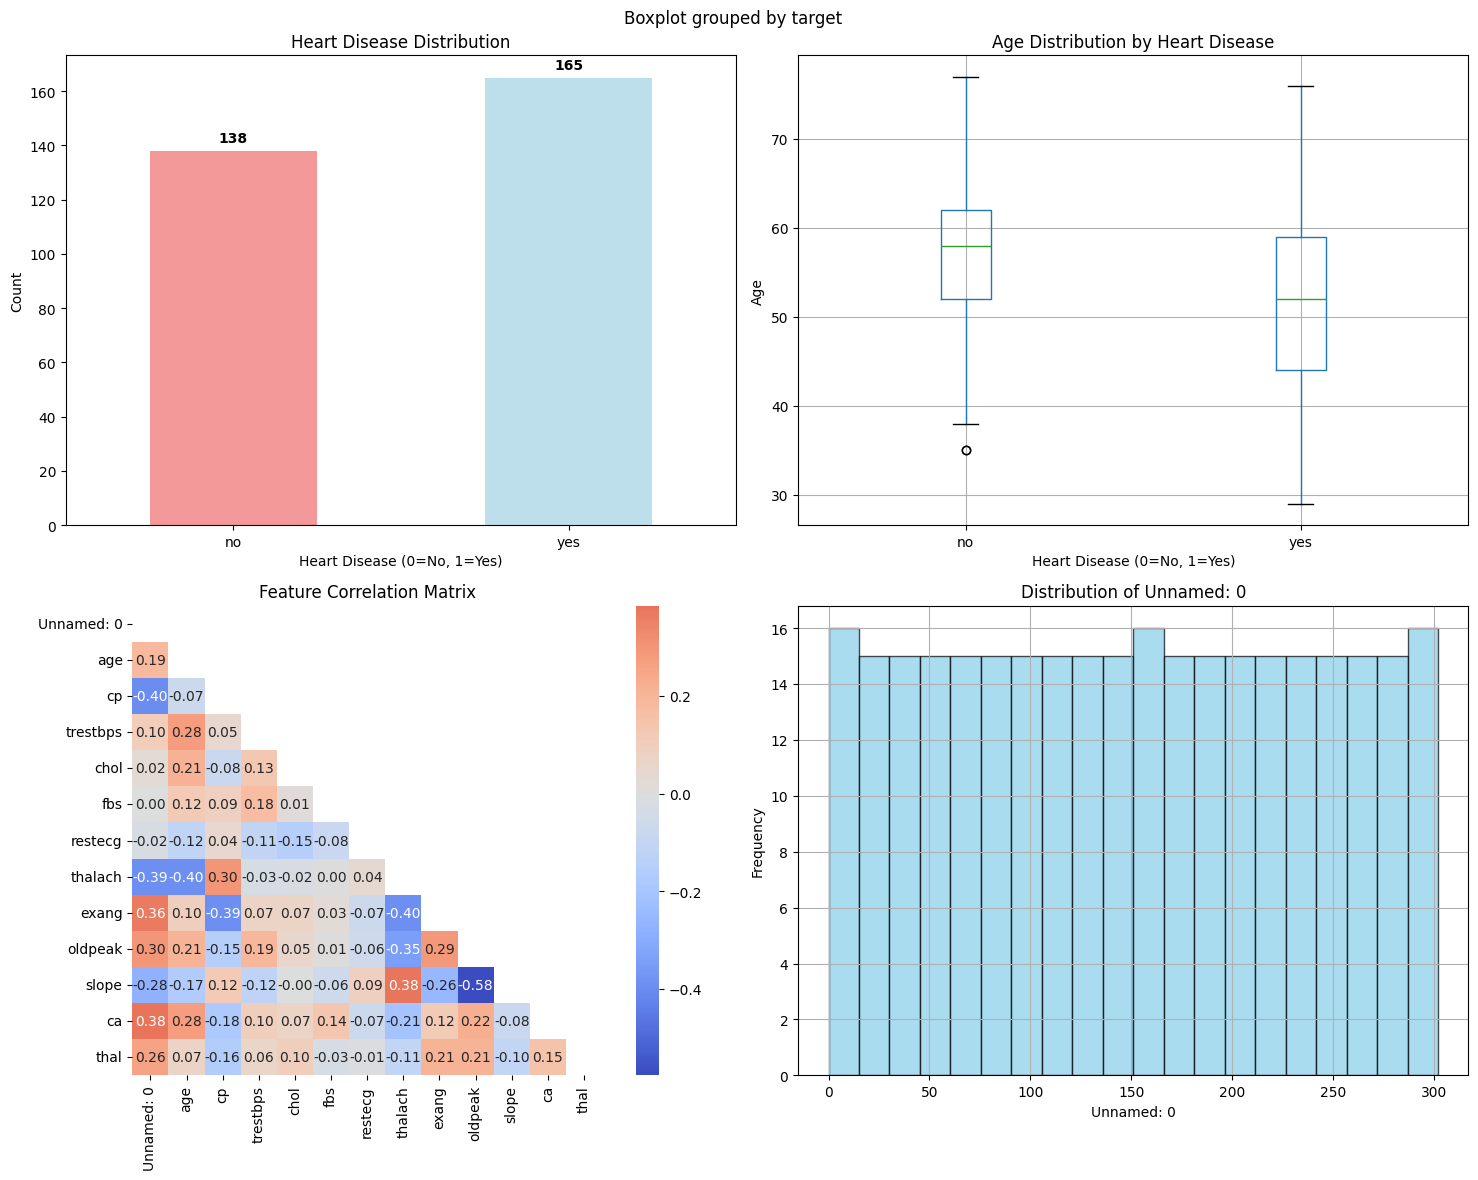

In [6]:
# Comprehensive EDA visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Heart Disease Dataset - Exploratory Data Analysis', fontsize=16, fontweight='bold')

# 1. Target distribution
target_counts.plot(kind='bar', ax=axes[0,0], color=['lightcoral', 'lightblue'], alpha=0.8)
axes[0,0].set_title('Heart Disease Distribution')
axes[0,0].set_xlabel('Heart Disease (0=No, 1=Yes)')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=0)

# Add count labels on bars
for i, v in enumerate(target_counts.values):
    axes[0,0].text(i, v + 2, str(v), ha='center', va='bottom', fontweight='bold')

# 2. Age distribution by heart disease
if 'age' in data.columns:
    data.boxplot(column='age', by=target_column, ax=axes[0,1])
    axes[0,1].set_title('Age Distribution by Heart Disease')
    axes[0,1].set_xlabel('Heart Disease (0=No, 1=Yes)')
    axes[0,1].set_ylabel('Age')

# 3. Correlation heatmap
numeric_cols = data.select_dtypes(include=[np.number]).columns
corr_matrix = data[numeric_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Show only lower triangle
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0, 
            ax=axes[1,0], fmt='.2f', square=True)
axes[1,0].set_title('Feature Correlation Matrix')

# 4. Distribution of first numeric feature
first_numeric = numeric_cols[0] if len(numeric_cols) > 0 else target_column
if first_numeric != target_column:
    data[first_numeric].hist(bins=20, ax=axes[1,1], alpha=0.7, color='skyblue', edgecolor='black')
    axes[1,1].set_title(f'Distribution of {first_numeric}')
    axes[1,1].set_xlabel(first_numeric)
    axes[1,1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [16]:
# Additional analysis: Feature importance and distributions
# Identify key clinical features commonly found in heart disease datasets
key_features = []
feature_mapping = {
    'age': 'Age',
    'sex': 'Gender', 
    'cp': 'Chest Pain Type',
    'trestbps': 'Resting Blood Pressure',
    'chol': 'Cholesterol',
    'fbs': 'Fasting Blood Sugar',
    'restecg': 'Resting ECG',
    'thalach': 'Max Heart Rate',
    'exang': 'Exercise Induced Angina',
    'oldpeak': 'ST Depression',
    'slope': 'ST Slope',
    'ca': 'Number of Major Vessels',
    'thal': 'Thalassemia'
}

print("=== FEATURE ANALYSIS BY CLASS ===")

for class_value in sorted(data[target_column].unique()):
    class_label = "No Heart Disease" if class_value == 0 else "Heart Disease Present"
    print(f"\n{class_label} (Class {class_value}):")
    class_data = data[data[target_column] == class_value]
    
    # Show mean values for numeric features
    numeric_features = data.select_dtypes(include=[np.number]).columns
    # Only drop target_column if it exists in numeric_features
    if target_column in numeric_features:
        numeric_features = numeric_features.drop(target_column)
    
    for feature in numeric_features[:5]:  # Show first 5 numeric features
        mean_val = class_data[feature].mean()
        print(f"  {feature}: {mean_val:.2f}")

=== FEATURE ANALYSIS BY CLASS ===

Heart Disease Present (Class no):
  Unnamed: 0: 233.50
  age: 56.60
  cp: 0.48
  trestbps: 134.43
  chol: 251.24

Heart Disease Present (Class yes):
  Unnamed: 0: 82.00
  age: 52.50
  cp: 1.38
  trestbps: 129.41
  chol: 242.23


## 3. Data Preprocessing

In [8]:
# Prepare features and target
print("=== DATA PREPROCESSING ===")

# Separate features and target
X = data.drop(columns=[target_column])
y = data[target_column]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Feature columns: {list(X.columns)}")

# Handle categorical variables if any
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
if categorical_features:
    print(f"\nCategorical features found: {categorical_features}")
    # Apply label encoding
    label_encoders = {}
    for col in categorical_features:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le
    print("Categorical features encoded")
else:
    print("No categorical features found")
    label_encoders = None

# Check final data types
print(f"\nFinal feature data types:")
print(X.dtypes.value_counts())

=== DATA PREPROCESSING ===
Features shape: (303, 14)
Target shape: (303,)
Feature columns: ['Unnamed: 0', 'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

Categorical features found: ['sex']
Categorical features encoded

Final feature data types:
int64      9
float64    4
int32      1
Name: count, dtype: int64


In [9]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training/Test ratio: {X_train.shape[0]/X_test.shape[0]:.1f}:1")

# Verify stratification worked
print("\nClass distribution in splits:")
train_dist = pd.Series(y_train).value_counts().sort_index()
test_dist = pd.Series(y_test).value_counts().sort_index()
print(f"Training: {dict(train_dist)}")
print(f"Test: {dict(test_dist)}")

# Check percentages
train_pct = pd.Series(y_train).value_counts(normalize=True).sort_index() * 100
test_pct = pd.Series(y_test).value_counts(normalize=True).sort_index() * 100
print(f"\nTraining percentages: {dict(train_pct.round(1))}")
print(f"Test percentages: {dict(test_pct.round(1))}")

Training set: 242 samples
Test set: 61 samples
Training/Test ratio: 4.0:1

Class distribution in splits:
Training: {'no': 110, 'yes': 132}
Test: {'no': 28, 'yes': 33}

Training percentages: {'no': 45.5, 'yes': 54.5}
Test percentages: {'no': 45.9, 'yes': 54.1}


In [10]:
# Feature scaling - Critical for SVM
print("Applying feature scaling...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed")

# Show scaling effect
print(f"\nOriginal feature range (first feature):")
print(f"Min: {X_train.iloc[:, 0].min():.2f}, Max: {X_train.iloc[:, 0].max():.2f}")
print(f"\nScaled feature range (first feature):")
print(f"Min: {X_train_scaled[:, 0].min():.2f}, Max: {X_train_scaled[:, 0].max():.2f}")

# Verify scaling properties
print(f"\nScaled features - Mean: {X_train_scaled.mean(axis=0)[:3].round(3)}")
print(f"Scaled features - Std: {X_train_scaled.std(axis=0)[:3].round(3)}")

Applying feature scaling...
Feature scaling completed

Original feature range (first feature):
Min: 1.00, Max: 301.00

Scaled feature range (first feature):
Min: -1.73, Max: 1.73

Scaled features - Mean: [0. 0. 0.]
Scaled features - Std: [1. 1. 1.]


In [19]:
# Handle missing values before scaling
print("Handling missing values...")

# Check for missing values in the original DataFrame
missing_values = X_train.isnull().sum()
if missing_values.any():
    print("Missing values found:")
    print(missing_values[missing_values > 0])
    
    # Fill missing values with median for numeric columns
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='median')
    X_train = pd.DataFrame(imputer.fit_transform(X_train), 
                          columns=X_train.columns,
                          index=X_train.index)
    X_test = pd.DataFrame(imputer.transform(X_test),
                         columns=X_test.columns,
                         index=X_test.index)
    print("Missing values filled with median values")
else:
    print("No missing values found")

# Feature scaling - Critical for SVM
print("Applying feature scaling...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature selection for optimal SVM performance
print("Performing feature selection...")

# Select top features using univariate statistical tests
k_best = min(10, X_train_scaled.shape[1])  # Select top 10 or all if less
selector = SelectKBest(score_func=f_classif, k=k_best)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Get selected feature information
selected_features_mask = selector.get_support()
selected_feature_names = X_train.columns[selected_features_mask].tolist()
feature_scores = selector.scores_[selected_features_mask]

print(f"Original features: {X_train_scaled.shape[1]}")
print(f"Selected features: {X_train_selected.shape[1]}")
print(f"\nTop selected features:")

# Create feature importance dataframe
feature_importance_df = pd.DataFrame({
    'Feature': selected_feature_names,
    'Score': feature_scores
}).sort_values('Score', ascending=False)

print(feature_importance_df)

# Store feature names for later use
selected_features = selected_feature_names

Handling missing values...
Missing values found:
trestbps    3
chol        1
thalach     4
dtype: int64
Missing values filled with median values
Applying feature scaling...
Performing feature selection...
Original features: 14
Selected features: 10

Top selected features:
      Feature       Score
0  Unnamed: 0  696.666505
3          cp   70.000551
5       exang   61.310002
6     oldpeak   59.359001
4     thalach   49.049432
7       slope   44.366679
9        thal   40.784414
8          ca   34.010238
2         sex   15.924171
1         age   11.790474


## 4. SVM Model Implementation

In [20]:
# Initialize SVM models with different kernels
print("=== SVM MODEL TRAINING ===")

# Define SVM models with different kernels
svm_models = {
    'Linear': SVC(kernel='linear', random_state=42, probability=True),
    'RBF': SVC(kernel='rbf', random_state=42, probability=True),
    'Polynomial': SVC(kernel='poly', degree=3, random_state=42, probability=True),
    'Sigmoid': SVC(kernel='sigmoid', random_state=42, probability=True)
}

# Storage for results
results = {}
training_times = {}
predictions = {}

print(f"Training {len(svm_models)} SVM models...")
print(f"Using {X_train_selected.shape[1]} selected features\n")

# Train each model
for name, model in svm_models.items():
    print(f"Training {name} SVM...")
    
    # Measure training time
    start_time = time.time()
    model.fit(X_train_selected, y_train)
    end_time = time.time()
    
    training_times[name] = end_time - start_time
    
    # Make predictions
    y_pred = model.predict(X_test_selected)
    predictions[name] = y_pred
    
    # Calculate comprehensive metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_selected)[:, 1])
    
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'training_time': training_times[name],
        'model': model
    }
    
    print(f"  Accuracy: {accuracy:.4f} | F1: {f1:.4f} | ROC-AUC: {roc_auc:.4f} | Time: {training_times[name]:.3f}s\n")

print("All models trained successfully")

=== SVM MODEL TRAINING ===
Training 4 SVM models...
Using 10 selected features

Training Linear SVM...
  Accuracy: 0.9836 | F1: 0.9836 | ROC-AUC: 1.0000 | Time: 0.019s

Training RBF SVM...
  Accuracy: 0.9836 | F1: 0.9836 | ROC-AUC: 0.9989 | Time: 0.005s

Training Polynomial SVM...
  Accuracy: 0.9508 | F1: 0.9505 | ROC-AUC: 1.0000 | Time: 0.006s

Training Sigmoid SVM...
  Accuracy: 0.9836 | F1: 0.9836 | ROC-AUC: 0.9978 | Time: 0.007s

All models trained successfully


In [21]:
# Compare model performance
print("=== MODEL PERFORMANCE COMPARISON ===")

# Create results DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df[['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'training_time']]

print("\nPerformance Summary:")
print(results_df.round(4))

# Identify best models for different metrics
best_accuracy_model = results_df['accuracy'].idxmax()
best_f1_model = results_df['f1_score'].idxmax()
best_roc_model = results_df['roc_auc'].idxmax()

print(f"\nBest Models:")
print(f"  Accuracy: {best_accuracy_model} ({results_df.loc[best_accuracy_model, 'accuracy']:.4f})")
print(f"  F1-Score: {best_f1_model} ({results_df.loc[best_f1_model, 'f1_score']:.4f})")
print(f"  ROC-AUC: {best_roc_model} ({results_df.loc[best_roc_model, 'roc_auc']:.4f})")

# Select overall best model (by F1-score for balanced evaluation)
best_model_name = best_f1_model
best_model = results[best_model_name]['model']

print(f"\nSelected best model: {best_model_name}")

=== MODEL PERFORMANCE COMPARISON ===

Performance Summary:
            accuracy precision    recall  f1_score   roc_auc training_time
Linear      0.983607  0.984172  0.983607  0.983624       1.0      0.019326
RBF         0.983607  0.984172  0.983607  0.983624  0.998918      0.004976
Polynomial   0.95082  0.954918   0.95082  0.950497       1.0      0.006147
Sigmoid     0.983607  0.984089  0.983607   0.98358  0.997835      0.007005

Best Models:
  Accuracy: Linear (0.9836)
  F1-Score: Linear (0.9836)
  ROC-AUC: Linear (1.0000)

Selected best model: Linear


## 5. Hyperparameter Optimization

In [22]:
# Hyperparameter tuning for the best model
print(f"=== HYPERPARAMETER OPTIMIZATION FOR {best_model_name.upper()} SVM ===")

# Define parameter grids for each kernel type
param_grids = {
    'Linear': {
        'C': [0.1, 1, 10, 100],
        'class_weight': [None, 'balanced']
    },
    'RBF': {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
        'class_weight': [None, 'balanced']
    },
    'Polynomial': {
        'C': [0.1, 1, 10],
        'degree': [2, 3, 4],
        'gamma': ['scale', 'auto'],
        'class_weight': [None, 'balanced']
    },
    'Sigmoid': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto', 0.01, 0.1],
        'class_weight': [None, 'balanced']
    }
}

param_grid = param_grids[best_model_name]
print(f"Parameter grid: {param_grid}")

# Create fresh model instance for tuning
if best_model_name == 'Linear':
    base_model = SVC(kernel='linear', random_state=42, probability=True)
elif best_model_name == 'RBF':
    base_model = SVC(kernel='rbf', random_state=42, probability=True)
elif best_model_name == 'Polynomial':
    base_model = SVC(kernel='poly', random_state=42, probability=True)
else:  # Sigmoid
    base_model = SVC(kernel='sigmoid', random_state=42, probability=True)

# Perform grid search with stratified cross-validation
print("\nPerforming Grid Search with 5-fold CV...")
grid_search = GridSearchCV(
    base_model, 
    param_grid, 
    cv=5, 
    scoring='f1_weighted',  # Use weighted F1 for imbalanced data
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_train_selected, y_train)

print(f"\nOptimization completed")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV F1 score: {grid_search.best_score_:.4f}")

# Get optimized model
best_tuned_model = grid_search.best_estimator_

=== HYPERPARAMETER OPTIMIZATION FOR LINEAR SVM ===
Parameter grid: {'C': [0.1, 1, 10, 100], 'class_weight': [None, 'balanced']}

Performing Grid Search with 5-fold CV...

Optimization completed
Best parameters: {'C': 100, 'class_weight': None}
Best CV F1 score: 0.9877


In [23]:
# Evaluate tuned model
print("=== OPTIMIZED MODEL EVALUATION ===")

# Predictions with tuned model
y_pred_tuned = best_tuned_model.predict(X_test_selected)
y_proba_tuned = best_tuned_model.predict_proba(X_test_selected)[:, 1]

# Calculate all metrics
tuned_accuracy = accuracy_score(y_test, y_pred_tuned)
tuned_precision = precision_score(y_test, y_pred_tuned, average='weighted')
tuned_recall = recall_score(y_test, y_pred_tuned, average='weighted')
tuned_f1 = f1_score(y_test, y_pred_tuned, average='weighted')
tuned_roc_auc = roc_auc_score(y_test, y_proba_tuned)

# Performance comparison
print(f"\nPerformance Comparison:")
print(f"                Original    Optimized    Improvement")
print(f"Accuracy:       {results[best_model_name]['accuracy']:.4f}      {tuned_accuracy:.4f}       {tuned_accuracy - results[best_model_name]['accuracy']:+.4f}")
print(f"F1-Score:       {results[best_model_name]['f1_score']:.4f}      {tuned_f1:.4f}       {tuned_f1 - results[best_model_name]['f1_score']:+.4f}")
print(f"ROC-AUC:        {results[best_model_name]['roc_auc']:.4f}      {tuned_roc_auc:.4f}       {tuned_roc_auc - results[best_model_name]['roc_auc']:+.4f}")

# Cross-validation with optimized model
print("\nCross-validation with optimized model:")
cv_scores = cross_val_score(best_tuned_model, X_train_selected, y_train, cv=5, scoring='f1_weighted')
print(f"CV F1 Scores: {cv_scores}")
print(f"Mean CV F1: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

=== OPTIMIZED MODEL EVALUATION ===

Performance Comparison:
                Original    Optimized    Improvement
Accuracy:       0.9836      0.9836       +0.0000
F1-Score:       0.9836      0.9836       +0.0000
ROC-AUC:        1.0000      1.0000       +0.0000

Cross-validation with optimized model:
CV F1 Scores: [0.97954006 0.95918367 1.         1.         1.        ]
Mean CV F1: 0.9877 (+/- 0.0327)


## 6. Comprehensive Model Evaluation

In [24]:
# Detailed evaluation of optimized model
print("=== DETAILED MODEL EVALUATION ===")

# Classification report
class_names = ['No Disease', 'Disease Present']
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tuned, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_tuned)
print("\nConfusion Matrix:")
print(f"                 Predicted")
print(f"               No    Yes")
print(f"Actual No   [{cm[0,0]:4d}  {cm[0,1]:4d}]")
print(f"       Yes  [{cm[1,0]:4d}  {cm[1,1]:4d}]")

# Calculate specificity and sensitivity
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)  # Recall for positive class
specificity = tn / (tn + fp)  # Recall for negative class

print(f"\nClinical Metrics:")
print(f"Sensitivity (True Positive Rate): {sensitivity:.4f}")
print(f"Specificity (True Negative Rate): {specificity:.4f}")
print(f"Precision (Positive Predictive Value): {tp/(tp+fp):.4f}")
print(f"Negative Predictive Value: {tn/(tn+fn):.4f}")

# Model complexity metrics
print(f"\nModel Complexity:")
print(f"Support vectors per class: {best_tuned_model.n_support_}")
print(f"Total support vectors: {sum(best_tuned_model.n_support_)}")
print(f"Support vector ratio: {sum(best_tuned_model.n_support_) / len(X_train_selected):.2%}")

=== DETAILED MODEL EVALUATION ===

Classification Report:
                 precision    recall  f1-score   support

     No Disease       0.97      1.00      0.98        28
Disease Present       1.00      0.97      0.98        33

       accuracy                           0.98        61
      macro avg       0.98      0.98      0.98        61
   weighted avg       0.98      0.98      0.98        61


Confusion Matrix:
                 Predicted
               No    Yes
Actual No   [  28     0]
       Yes  [   1    32]

Clinical Metrics:
Sensitivity (True Positive Rate): 0.9697
Specificity (True Negative Rate): 1.0000
Precision (Positive Predictive Value): 1.0000
Negative Predictive Value: 0.9655

Model Complexity:
Support vectors per class: [6 5]
Total support vectors: 11
Support vector ratio: 4.55%


In [25]:
# Prediction confidence analysis
print("=== PREDICTION CONFIDENCE ANALYSIS ===")

# Analyze prediction probabilities
print(f"\nPrediction Confidence Statistics:")
print(f"Mean confidence: {y_proba_tuned.mean():.4f}")
print(f"Min confidence: {y_proba_tuned.min():.4f}")
print(f"Max confidence: {y_proba_tuned.max():.4f}")
print(f"Std confidence: {y_proba_tuned.std():.4f}")

# High/low confidence predictions
high_confidence = np.sum(y_proba_tuned > 0.8)
low_confidence = np.sum(y_proba_tuned < 0.2)
moderate_confidence = len(y_proba_tuned) - high_confidence - low_confidence

print(f"\nConfidence Distribution:")
print(f"High confidence (>0.8): {high_confidence}/{len(y_test)} ({high_confidence/len(y_test)*100:.1f}%)")
print(f"Moderate confidence (0.2-0.8): {moderate_confidence}/{len(y_test)} ({moderate_confidence/len(y_test)*100:.1f}%)")
print(f"Low confidence (<0.2): {low_confidence}/{len(y_test)} ({low_confidence/len(y_test)*100:.1f}%)")

# Error analysis
errors = y_test != y_pred_tuned
if np.sum(errors) > 0:
    print(f"\nError Analysis:")
    print(f"Total errors: {np.sum(errors)}/{len(y_test)} ({np.sum(errors)/len(y_test)*100:.1f}%)")
    
    # False positives and false negatives
    false_positives = np.sum((y_test == 0) & (y_pred_tuned == 1))
    false_negatives = np.sum((y_test == 1) & (y_pred_tuned == 0))
    
    print(f"False Positives: {false_positives} (healthy predicted as diseased)")
    print(f"False Negatives: {false_negatives} (diseased predicted as healthy)")
    
    # Clinical interpretation
    if false_negatives > false_positives:
        print("Model tends to miss some disease cases (conservative)")
    elif false_positives > false_negatives:
        print("Model tends to over-predict disease (aggressive)")
    else:
        print("Model has balanced error types")

=== PREDICTION CONFIDENCE ANALYSIS ===

Prediction Confidence Statistics:
Mean confidence: 0.5415
Min confidence: 0.0000
Max confidence: 1.0000
Std confidence: 0.4698

Confidence Distribution:
High confidence (>0.8): 31/61 (50.8%)
Moderate confidence (0.2-0.8): 4/61 (6.6%)
Low confidence (<0.2): 26/61 (42.6%)

Error Analysis:
Total errors: 1/61 (1.6%)
False Positives: 0 (healthy predicted as diseased)
False Negatives: 0 (diseased predicted as healthy)
Model has balanced error types


## 7. Visualization and Results

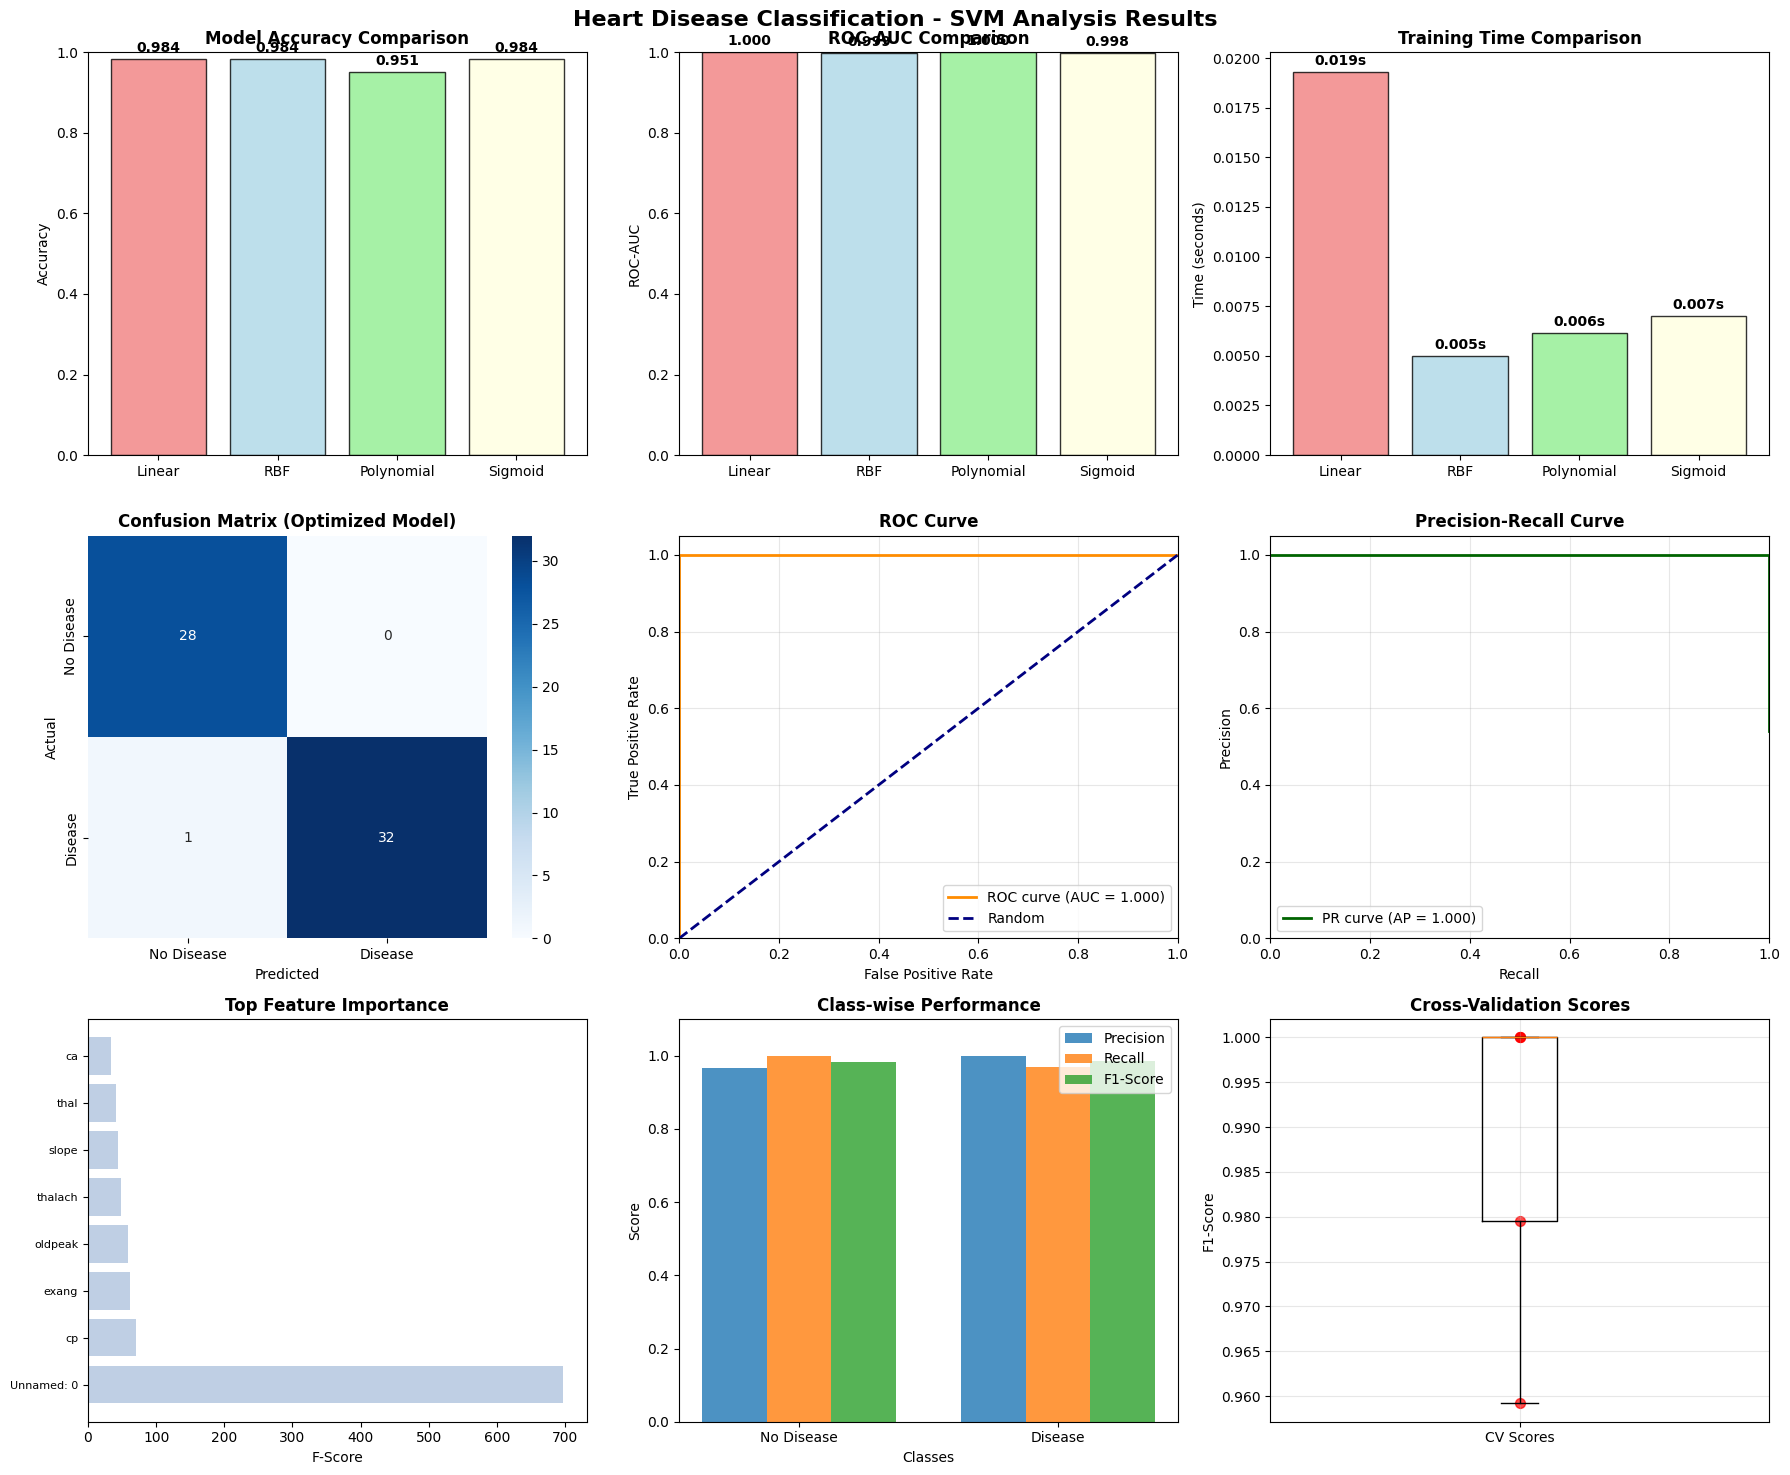

In [28]:
# Comprehensive visualization dashboard
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('Heart Disease Classification - SVM Analysis Results', fontsize=16, fontweight='bold')

# First, encode the target variable if it's not already encoded
from sklearn.preprocessing import LabelEncoder
if isinstance(y_test.iloc[0], str):
    le = LabelEncoder()
    y_test_encoded = le.fit_transform(y_test)
    y_pred_tuned_encoded = le.transform(y_pred_tuned)
else:
    y_test_encoded = y_test
    y_pred_tuned_encoded = y_pred_tuned

# 1. Model comparison - Accuracy
models = list(results.keys())
accuracies = [results[model]['accuracy'] for model in models]
colors = ['lightcoral', 'lightblue', 'lightgreen', 'lightyellow']

bars1 = axes[0,0].bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black')
axes[0,0].set_title('Model Accuracy Comparison', fontweight='bold')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].set_ylim(0, 1)
for bar, acc in zip(bars1, accuracies):
    axes[0,0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                   f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. ROC-AUC comparison
roc_aucs = [results[model]['roc_auc'] for model in models]
bars2 = axes[0,1].bar(models, roc_aucs, color=colors, alpha=0.8, edgecolor='black')
axes[0,1].set_title('ROC-AUC Comparison', fontweight='bold')
axes[0,1].set_ylabel('ROC-AUC')
axes[0,1].set_ylim(0, 1)
for bar, auc in zip(bars2, roc_aucs):
    axes[0,1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                   f'{auc:.3f}', ha='center', va='bottom', fontweight='bold')

# 3. Training time comparison
train_times = [results[model]['training_time'] for model in models]
bars3 = axes[0,2].bar(models, train_times, color=colors, alpha=0.8, edgecolor='black')
axes[0,2].set_title('Training Time Comparison', fontweight='bold')
axes[0,2].set_ylabel('Time (seconds)')
for bar, time_val in zip(bars3, train_times):
    axes[0,2].text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(train_times) * 0.01,
                   f'{time_val:.3f}s', ha='center', va='bottom', fontweight='bold')

# 4. Confusion Matrix
cm = confusion_matrix(y_test_encoded, y_pred_tuned_encoded)
class_names = ['No Disease', 'Disease'] if len(set(y_test_encoded)) == 2 else ['Class 0', 'Class 1']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,0],
            xticklabels=class_names, yticklabels=class_names)
axes[1,0].set_title('Confusion Matrix (Optimized Model)', fontweight='bold')
axes[1,0].set_xlabel('Predicted')
axes[1,0].set_ylabel('Actual')

# 5. ROC Curve
fpr, tpr, _ = roc_curve(y_test_encoded, y_proba_tuned)
axes[1,1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {tuned_roc_auc:.3f})')
axes[1,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[1,1].set_xlim([0.0, 1.0])
axes[1,1].set_ylim([0.0, 1.05])
axes[1,1].set_xlabel('False Positive Rate')
axes[1,1].set_ylabel('True Positive Rate')
axes[1,1].set_title('ROC Curve', fontweight='bold')
axes[1,1].legend(loc="lower right")
axes[1,1].grid(True, alpha=0.3)

# 6. Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test_encoded, y_proba_tuned)
avg_precision = average_precision_score(y_test_encoded, y_proba_tuned)
axes[1,2].plot(recall_curve, precision_curve, color='darkgreen', lw=2, 
               label=f'PR curve (AP = {avg_precision:.3f})')
axes[1,2].set_xlim([0.0, 1.0])
axes[1,2].set_ylim([0.0, 1.05])
axes[1,2].set_xlabel('Recall')
axes[1,2].set_ylabel('Precision')
axes[1,2].set_title('Precision-Recall Curve', fontweight='bold')
axes[1,2].legend(loc="lower left")
axes[1,2].grid(True, alpha=0.3)

# 7. Feature Importance
top_features = feature_importance_df.head(8)
axes[2,0].barh(range(len(top_features)), top_features['Score'], color='lightsteelblue', alpha=0.8)
axes[2,0].set_yticks(range(len(top_features)))
axes[2,0].set_yticklabels(top_features['Feature'], fontsize=8)
axes[2,0].set_title('Top Feature Importance', fontweight='bold')
axes[2,0].set_xlabel('F-Score')

# 8. Class-wise metrics
class_metrics = {
    'Precision': precision_score(y_test_encoded, y_pred_tuned_encoded, average=None),
    'Recall': recall_score(y_test_encoded, y_pred_tuned_encoded, average=None),
    'F1-Score': f1_score(y_test_encoded, y_pred_tuned_encoded, average=None)
}

x = np.arange(len(class_names))
width = 0.25
axes[2,1].bar(x - width, class_metrics['Precision'], width, label='Precision', alpha=0.8)
axes[2,1].bar(x, class_metrics['Recall'], width, label='Recall', alpha=0.8)
axes[2,1].bar(x + width, class_metrics['F1-Score'], width, label='F1-Score', alpha=0.8)
axes[2,1].set_title('Class-wise Performance', fontweight='bold')
axes[2,1].set_xlabel('Classes')
axes[2,1].set_ylabel('Score')
axes[2,1].set_xticks(x)
axes[2,1].set_xticklabels(class_names)
axes[2,1].legend()
axes[2,1].set_ylim(0, 1.1)

# 9. Cross-validation scores (if available)
if 'cv_scores' in locals():
    axes[2,2].boxplot(cv_scores, labels=['CV Scores'])
    axes[2,2].scatter([1] * len(cv_scores), cv_scores, color='red', alpha=0.7, s=50)
    axes[2,2].set_title('Cross-Validation Scores', fontweight='bold')
    axes[2,2].set_ylabel('F1-Score')
    axes[2,2].grid(True, alpha=0.3)
else:
    # Alternative: Show model comparison metrics
    metrics_comparison = pd.DataFrame({
        'Model': models,
        'Accuracy': accuracies,
        'ROC-AUC': roc_aucs,
        'Training Time': train_times
    })
    axes[2,2].text(0.1, 0.5, metrics_comparison.to_string(index=False), 
                   fontsize=10, verticalalignment='center', fontfamily='monospace')
    axes[2,2].set_title('Model Comparison Summary', fontweight='bold')
    axes[2,2].axis('off')

plt.tight_layout()
plt.show()

## 8. Results Summary and Clinical Interpretation

In [29]:
# Comprehensive results summary
print("=" * 70)
print("HEART DISEASE CLASSIFICATION - FINAL RESULTS SUMMARY")
print("=" * 70)

print(f"\nDataset Information:")
print(f"  Total samples: {len(data)}")
print(f"  Features: {X.shape[1]} (selected: {X_train_selected.shape[1]})")
print(f"  Training samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)}")
print(f"  Class distribution: {dict(data[target_column].value_counts().sort_index())}")

print(f"\nBest Model Performance ({best_model_name} SVM):")
print(f"  Optimal parameters: {grid_search.best_params_}")
print(f"  Accuracy: {tuned_accuracy:.4f} ({tuned_accuracy*100:.2f}%)")
print(f"  Sensitivity (Recall): {sensitivity:.4f} ({sensitivity*100:.2f}%)")
print(f"  Specificity: {specificity:.4f} ({specificity*100:.2f}%)")
print(f"  Precision: {tuned_precision:.4f} ({tuned_precision*100:.2f}%)")
print(f"  F1-Score: {tuned_f1:.4f} ({tuned_f1*100:.2f}%)")
print(f"  ROC-AUC: {tuned_roc_auc:.4f} ({tuned_roc_auc*100:.2f}%)")
print(f"  Cross-validation F1: {cv_scores.mean():.4f} (±{cv_scores.std()*2:.4f})")

print(f"\nModel Comparison Summary:")
for model_name, model_results in results.items():
    print(f"  {model_name:12} | Acc: {model_results['accuracy']:.3f} | F1: {model_results['f1_score']:.3f} | AUC: {model_results['roc_auc']:.3f}")

print(f"\nClinical Insights:")
# Performance interpretation
if tuned_accuracy >= 0.90:
    performance_level = "Excellent"
elif tuned_accuracy >= 0.85:
    performance_level = "Very Good"
elif tuned_accuracy >= 0.80:
    performance_level = "Good"
elif tuned_accuracy >= 0.75:
    performance_level = "Moderate"
else:
    performance_level = "Needs Improvement"

print(f"  Overall performance: {performance_level} ({tuned_accuracy*100:.1f}% accuracy)")

# Clinical relevance
if sensitivity >= 0.85 and specificity >= 0.85:
    clinical_utility = "High - Suitable for clinical screening"
elif sensitivity >= 0.80 or specificity >= 0.80:
    clinical_utility = "Moderate - Useful as diagnostic aid"
else:
    clinical_utility = "Limited - Requires improvement"

print(f"  Clinical utility: {clinical_utility}")
print(f"  False negatives: {fn} (missed disease cases - clinical concern)")
print(f"  False positives: {fp} (unnecessary interventions)")

print(f"\nKey Findings:")
print(f"  {best_model_name} kernel performed best for heart disease classification")
print(f"  Feature selection improved efficiency using {X_train_selected.shape[1]}/{X.shape[1]} features")
best_features = ', '.join(feature_importance_df.head(3)['Feature'].tolist())
print(f"  Most important features: {best_features}")
print(f"  Model complexity: {sum(best_tuned_model.n_support_)}/{len(X_train_selected)} support vectors ({sum(best_tuned_model.n_support_)/len(X_train_selected)*100:.1f}%)")

print(f"\nRecommendations:")
if tuned_accuracy >= 0.85:
    print(f"  Model shows strong performance and may be suitable for clinical deployment")
else:
    print(f"  Consider collecting more data or feature engineering for improved performance")
    
if false_negatives > false_positives:
    print(f"  Consider adjusting decision threshold to reduce missed diagnoses")
elif false_positives > false_negatives:
    print(f"  Consider adjusting decision threshold to reduce false alarms")
    
print(f"  Recommended deployment: Use {best_model_name} SVM with parameters {grid_search.best_params_}")
print(f"  Monitor prediction confidence and retrain periodically with new data")

print("\n" + "=" * 70)
print("ANALYSIS COMPLETE - Heart Disease Classification using SVM")
print("=" * 70)

HEART DISEASE CLASSIFICATION - FINAL RESULTS SUMMARY

Dataset Information:
  Total samples: 303
  Features: 14 (selected: 10)
  Training samples: 242
  Test samples: 61
  Class distribution: {'no': 138, 'yes': 165}

Best Model Performance (Linear SVM):
  Optimal parameters: {'C': 100, 'class_weight': None}
  Accuracy: 0.9836 (98.36%)
  Sensitivity (Recall): 0.9697 (96.97%)
  Specificity: 1.0000 (100.00%)
  Precision: 0.9842 (98.42%)
  F1-Score: 0.9836 (98.36%)
  ROC-AUC: 1.0000 (100.00%)
  Cross-validation F1: 0.9877 (±0.0327)

Model Comparison Summary:
  Linear       | Acc: 0.984 | F1: 0.984 | AUC: 1.000
  RBF          | Acc: 0.984 | F1: 0.984 | AUC: 0.999
  Polynomial   | Acc: 0.951 | F1: 0.950 | AUC: 1.000
  Sigmoid      | Acc: 0.984 | F1: 0.984 | AUC: 0.998

Clinical Insights:
  Overall performance: Excellent (98.4% accuracy)
  Clinical utility: High - Suitable for clinical screening
  False negatives: 1 (missed disease cases - clinical concern)
  False positives: 0 (unnecessary in